In [92]:
import sys
colab = True if 'google.colab' in sys.modules else False
colab

False

# Large scale text analysis with deep learning

Today we're gonna apply the newly learned tools for the task of predicting job salary.

In [93]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### About the challenge
For starters, let's download and unpack the data from [here](https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=0). 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [kaggle](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [94]:
if colab:
        #   https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz
    !wget https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz
    !tar -xvzf ./Train_rev1.csv.tar.gz
    # throw an exception "not a tar file"
else:
    import requests
    import tarfile
    from pathlib import Path

    # URL of the file to download
    # url = ""
    # Local file path to save the downloaded file
    data_dir = Path('/Users/velo1/SynologyDrive/GIT_syno/data/CNN')
    file_path = data_dir / "Train_rev1.csv.tar.gz"
    # /Users/velo1/SynologyDrive/GIT_syno/data/CNN/Train_rev1.csv.tar.gz

    # Check if the file already exists
    if not os.path.exists(file_path):
        # Download the file
        response = requests.get(url)
        with open(file_path, "wb") as file:
            file.write(response.content)
        print("File downloaded successfully.")
    else:
        print("File already exists. Skipping download.")

    # Extract the tar.gz file
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(data_dir)
        print("File extracted successfully.")

    # Remove the downloaded tar.gz file
    # os.remove(file_path)

data = pd.read_csv(data_dir / "Train_rev1.csv", index_col=None)
data.info()

File already exists. Skipping download.
File extracted successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this:  
* using a different loss function, 
* predicting log-target instead of raw target 
* or even replacing targets with their percentiles among all salaries in the training set. 
* We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

In [95]:
data.describe().T

count          mean           std         min  \
Id                244768.0  6.970142e+07  3.129813e+06  12612628.0   
SalaryNormalized  244768.0  3.412258e+04  1.764054e+04      5000.0   

                         25%         50%          75%         max  
Id                68695501.0  69936996.5  71626061.75  72705235.0  
SalaryNormalized     21500.0     30000.0     42500.00    200000.0

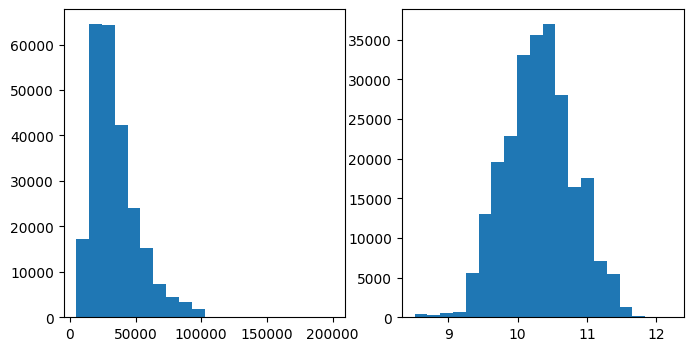

In [96]:
# The purpose of using np.log1p instead of np.log is to avoid numerical instability issues when x is close to zero. 
# By adding 1 to x before taking the logarithm, we ensure that the function behaves well even for very small values of x.
# To reverse the transformation and obtain the original values from the logarithmic scale, you can use the np.expm1 function. 
# The np.expm1 function calculates exp(x) - 1
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32') 

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [97]:
# Create a figure with subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("SalaryNormalized", "Log1pSalary"), shared_yaxes=False)

# Plot histogram for SalaryNormalized
fig.add_trace(go.Histogram(x=data["SalaryNormalized"], nbinsx=50), row=1, col=1)

# Plot histogram for Log1pSalary
fig.add_trace(go.Histogram(x=data["Log1pSalary"], nbinsx=50), row=1, col=2)

# Update x-axis and y-axis titles
fig.update_xaxes(title_text="Salary Normalized", row=1, col=1)
fig.update_xaxes(title_text="Log1p of SalaryNormalized", row=1, col=2)
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=2)
# Update figure layout
fig.update_layout(showlegend=False,height=600, width=1200)


Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [98]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

# the fact of missing value is also a feature that can be used to predict the target value
# we will replace missing values with a string "NaN"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"


data.sample(3)

Id                            Title  \
204797  72115634      Strategic Marketing Manager   
155245  71080411  Net Developer/Software Engineer   
28325   67948652         Web Developer  ASPNet, C   

                                                                                                                                                                                                                                                                                                    FullDescription  \
204797  Strategic Marketing Manager ****  **** plus car Based: Surrey TL**** We need the best of the best for this challenging and pivotal role for a major name in the consumer brand / QSR world. You will sit at the heart of consumer insight and thought leadership with a remit for driving growth and cre...   
155245  .Net Developer/Software Engineer (Leading C, ASP.NET apps) We are seeking a passionate .NET Developer or Software Engineer with a broad mix of technical knowledge including Visual Studio, C, ASP.NET and web and mobile technologies to deliver creative web, mobile and enterprise solutions for an i...   
28325   Our client is currently looking for a Web Developer, you will be part of the team that will develop new functionality to their existing Online website. Focusing on using ASP.net, C and SQL along with Excel, Access (Jet SQL), Visual Basic for Applications SQL Server, (SSIS, SSAS, SSRS), Transact ...   

                                       LocationRaw LocationNormalized  \
204797                                  South East  South East London   
155245  Hertfordshire Letchworth Garden City SG6 1            Willian   
28325                               Leicestershire     Leicestershire   

       ContractType ContractTime                    Company  \
204797          NaN     contract                        NaN   
155245          NaN    permanent  Understanding Recruitment   
28325           NaN    permanent       Certes Computing Ltd   

                                Category                        SalaryRaw  \
204797  PR, Advertising & Marketing Jobs                        50k - 60k   
155245                           IT Jobs   30000.00 - 40000.00 GBP Annual   
28325                            IT Jobs  30k - 35k pa + Company Benefits   

        SalaryNormalized                 SourceName  Log1pSalary  
204797             55000  simplymarketingjobs.co.uk    10.915107  
155245             35000               jobserve.com    10.463132  
28325              32500              jobsite.co.uk    10.389026

### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [99]:
# Set the option to display full text in columns
pd.set_option('display.max_colwidth', 300)

# Make the text left-justified
    # pd.set_option('display.colheader_justify', 'left')

In [100]:
print("Raw text:")
# print out every 50000th row of the FullDescription column
data["FullDescription"][::50000]

Raw text:


0         Engineering Systems Analyst Dorking Surrey Salary ****K Our client is located in Dorking, Surrey and are looking for Engineering Systems Analyst our client provides specialist software development Keywords Mathematical Modelling, Risk Analysis, System Modelling, Optimisation, MISER, PIONEEER Eng...
50000     Smart Metering Project Manager (Complex Network, Infrastructure, Complex Data Flows, SDLC, Prince****) Axica Recruitment is currently looking for a Smart Metering Project Manager to join a major end user in the North of England. My client is a market leader in its field, with over **** million c...
100000    We are looking for a HR advisor to join our team for a maternity cover. The role is full time, Monday to Friday. The successful candidate will have a proven track record of working within HR, preferably within the education sector. You will be responsible for keeping the college employee databas...
150000    Position  Programmes Director Location  Hampshire (RG Postco

In [101]:
import nltk # the Natural Language Toolkit (NLTK) 

tokenizer = nltk.tokenize.WordPunctTokenizer()

# lower case and tokenize the text splitting by a space in between
data["FullDescription"] = data["FullDescription"].astype(str).apply(
    lambda x: ' '.join(tokenizer.tokenize(x.lower())), 1)
data["Title"] = data["Title"].astype(str).apply(
    lambda x: ' '.join(tokenizer.tokenize(x.lower())), 1)
data["FullDescription"][::50000]

0         engineering systems analyst dorking surrey salary **** k our client is located in dorking , surrey and are looking for engineering systems analyst our client provides specialist software development keywords mathematical modelling , risk analysis , system modelling , optimisation , miser , pione...
50000     smart metering project manager ( complex network , infrastructure , complex data flows , sdlc , prince ****) axica recruitment is currently looking for a smart metering project manager to join a major end user in the north of england . my client is a market leader in its field , with over **** m...
100000    we are looking for a hr advisor to join our team for a maternity cover . the role is full time , monday to friday . the successful candidate will have a proven track record of working within hr , preferably within the education sector . you will be responsible for keeping the college employee da...
150000    position programmes director location hampshire ( rg postcod

Now we can assume that our text is a space-separated list of tokens:

In [102]:
print("Tokenized:")
print(data["FullDescription"][0::50000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
0         engineering systems analyst dorking surrey salary **** k our client is located in dorking , surrey and are looking for engineering systems analyst our client provides specialist software development keywords mathematical modelling , risk analysis , system modelling , optimisation , miser , pione...
50000     smart metering project manager ( complex network , infrastructure , complex data flows , sdlc , prince ****) axica recruitment is currently looking for a smart metering project manager to join a major end user in the north of england . my client is a market leader in its field , with over **** m...
100000    we are looking for a hr advisor to join our team for a maternity cover . the role is full time , monday to friday . the successful candidate will have a proven track record of working within hr , preferably within the education sector . you will be responsible for keeping the college employee da...
150000    position programmes director location hampshire (

Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [103]:
# Count how many times does each token occur in both "Title" and "FullDescription" in total
# build a dictionary { token -> it's count }
from collections import Counter

tokens = []
for title in data["Title"]:
    tokens += title.split()
for title in data["FullDescription"]:
    tokens += title.split()
    
token_counts = Counter(tokens)

# hint: you may or may not want to use collections.Counter

In [104]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


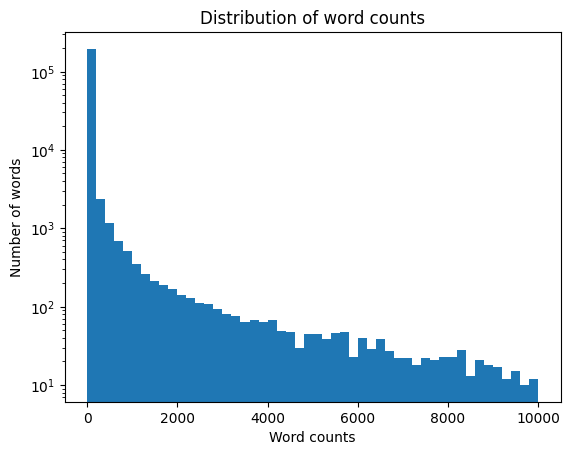

In [105]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts")
plt.ylabel("Number of words");
plt.title("Distribution of word counts");
plt

fig = px.histogram(list(token_counts.values()), log_y=True, range_x=[0, 300000])
fig.update_layout(title="Distribution of word counts", xaxis_title="Word counts", yaxis_title="Number of words")


Now filter tokens a list of all tokens that occur at least 10 times.

In [106]:
print("Vocabulary size:", len(tokens))
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]
print("Vocabulary size after filtering:", len(tokens))

Vocabulary size: 68753211
Vocabulary size after filtering: 34156


The kids went to play volllleyball in the garddden

The kids went to play in the

The kids went to play <UNK> in the <UNK> <PAD>

In [107]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")
tokens[:10]

Vocabulary size: 34158
Correct!


['UNK', 'PAD', '"', '$', '$****', '$****$****', '$****;', '%', '%)', '%),']

Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [110]:
token_to_id = {token: id for id, token in enumerate(tokens)}
print("Vocabulary size:", len(token_to_id))

list(token_to_id.items())[:10]

Vocabulary size: 34158


[('UNK', 0),
 ('PAD', 1),
 ('"', 2),
 ('$', 3),
 ('$****', 4),
 ('$****$****', 5),
 ('$****;', 6),
 ('%', 7),
 ('%)', 8),
 ('%),', 9)]

In [112]:
assert isinstance(token_to_id, dict)    # token_to_id must be a dictionary
assert len(token_to_id) == len(tokens)  # the dictionary must contain an id for each token
for tok in tokens:
    #  each token must have its own id
    #  each id must correspond to a token
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [116]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])   # get ids of special tokens
print(UNK_IX, PAD_IX)

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):                # if  elements first element is a string
        sequences = list(map(str.split, sequences))  # then split all elements into tokens
        
    # find the maximum length among all the sequences
    #                                       
    # finally limit to max_len if max_len is None. Otherwise, it defaults to infinity 
    max_len = min ( max(map(len, sequences)),        max_len or float('inf'))
    

    # create a matrix of shape len(sequences) x max_len and fill it with padding values (PAD_IX)
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))

    # paste sequences into the matrix
    for i,seq in enumerate(sequences):
        # limit the  sequence to  max_len
        # convert all tokens into token ids using token_to_id
        # If the word is present in the dictionary, it returns the associated ID; otherwise, it returns the ID of the unknown token (UNK_IX).
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        # past each row_ix into the i-th row of the matrix
        matrix[i, :len(row_ix)] = row_ix
    return matrix

0 1


List[str] -> (batch_size, max_len)

In [128]:
data["Title"][::100000]

0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object

In [118]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


let's vectorize the arbitrary text sequences into a fixed-size matrix.

In [140]:
as_matrix(["data", "data scientist data engineer", "scientist data", "hr master data"], max_len=4)

array([[ 8418,     1,     1,     1],
       [ 8418, 27287,  8418, 10804],
       [27287,  8418,     1,     1],
       [15020, 19143,  8418,     1]], dtype=int32)

Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [144]:
Counter(data['Company']).most_common(1000)[:5]

[('NaN', 32430),
 ('UKStaffsearch', 4997),
 ('CVbrowser', 2977),
 ('London4Jobs', 2345),
 ('Hays', 1784)]

In [154]:
# The DictVectorizer is designed to convert dictionaries into a numerical representation suitable for machine learning algorithms.
# It allows us to transform categorical variables into a one-hot encoded format.

from sklearn.feature_extraction import DictVectorizer   # to transform categorical features into a numerical representation
                                                        # this is a tool similar to CountVectorizer but for dictionaries

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
print(f'Number of Top common companies:{len(top_companies)}, counts: {len(top_counts)}')
# unique companies that we encounter in the data
recognized_companies = set(top_companies)
print(f'Number of unique companies:{len(recognized_companies)}')

# we replace all the other companies with "Other" category
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)     # we use float32 to save memory and the resulting matrix should be a dense array

# applies the dict function to each row of the selected columns, converting 
# the row values into dictionaries with column names as keys and row values as values.
# This step is necessary since DictVectorizer expects input in the form of dictionaries.
print(data[categorical_columns].apply(dict, axis=1)[0])               

#  fit categorical data in order to transform categorical features into a numerical representation suitable for machine learning algorithms.
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))   

Number of Top common companies:1000, counts: 1000
Number of unique companies:1000
{'Category': 'Engineering Jobs', 'Company': 'Gregory Martin International', 'LocationNormalized': 'Dorking', 'ContractType': 'NaN', 'ContractTime': 'permanent'}


DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a `small crime here: we used the whole data for tokenization and vocabulary building.`  
 A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [156]:
type(data)

pandas.core.frame.DataFrame

In [158]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

# By default, the index values of the original DataFrame are preserved in the subsets, 
# which means that the indices may not be consecutive.
# The purpose of resetting the index is to ensure that the index values of the subsets are consecutive integers starting from 0. 
# This can be useful for various operations and calculations that rely on consecutive integer indices, 
# such as iteration, indexing, and merging with other DataFrames.
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))
print("Train share = ", len(data_train) / len(data))
print(data_val.index)

Train size =  195814
Validation size =  48954
Train share =  0.7999983657994509
RangeIndex(start=0, stop=48954, step=1)


In [160]:
UNK_IX

0

In [161]:
def make_batch(data, max_len=None, word_dropout=0) -> dict:
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]}
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,) -> np.ndarray:
    '''Applies a word dropout to the input matrix by randomly dropping or replacing words based 
    on the specified keep probability. 
    :param matrix: The input matrix of word indices.
    :param keep_prop: a float value between 0 and 1 indicating the probability of keeping a word index
    :param replace_with: a word index to replace dropped words with (default: the unknown token '<UNK>' index)
    :param pad_ix: a word index of the padding token (default: the padding token '<PAD>' index)
    :returns: a matrix with dropped words
    '''

    # The dropout mask is a binary matrix where each element is either 0 or 1, indicating whether to keep or drop a word.
    # the value 2 represents the number of possible values that the elements of the dropout mask can take. 
    # In this case, the dropout mask is a binary matrix, where each element can be either 0 or 1.
    # The np.random.choice function is used to generate the dropout mask by randomly choosing values from the given set of options. 
    # Here, the options are [0, 1], and the probability distribution p specifies the probabilities of choosing each option.
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])

    # The dropout mask is applied element-wise to the input matrix using the bitwise AND operator (&). 
    # This ensures that words are dropped only if they are not equal to the padding index (pad_ix)
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [162]:
make_batch(data_train[:3], max_len=10)

{'Title': array([[27645, 29893, 33674,     1,     1,     1,     1],
        [29239,   197, 19175, 20042, 15554, 23162,  4051],
        [10609, 30412, 17746,    33,  8705, 29157,    65]], dtype=int32),
 'FullDescription': array([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451,
         32939],
        [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,
            82],
        [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412,
         17746]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32)}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use __[Keras Functional API](https://keras.io/models/model/)__.

In [163]:
import keras
import keras.layers as L

2023-06-05 11:43:23.639658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [164]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    
    
    emb = L.Embedding(n_tokens, 2 * hid_size)
    # 1. title and description -> embeddings 
    l_title_emb = emb(l_title)  # shape: [batch_size, title_len, emb_size]
    l_descr_emb = emb(l_descr)  # shape: [batch_size, descr_len, emb_size]
    
    # apply convolutional filters to title and description
    l_title_conv = L.Convolution1D(hid_size, kernel_size=2, activation='relu')(l_title_emb)
    l_descr_conv = L.Convolution1D(hid_size, kernel_size=5, activation='relu')(l_descr_emb)
    # apply global max pooling to title and description
    l_title_out = L.GlobalMaxPool1D()(l_title_conv)
    l_descr_out = L.GlobalMaxPool1D()(l_descr_conv)
    
    # 2. category features -> dense 
    l_categ_out = L.Dense(hid_size, activation='relu')(l_categ)
    # 3. Concatenate title, description and categorical features layers
    l_combined = L.Concatenate()([l_title_out, l_descr_out, l_categ_out])
    # 4. Add dense layers with relu for classification
    l_dense_clf = L.Dense(hid_size, activation='relu')(l_combined)
    
    # 5. Predict the output
    output_layer = L.Dense(1)(l_dense_clf)
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model
    

In [165]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Title (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 FullDescription (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    4372224     ['Title[0][0]',                  
                                                                  'FullDescription[0][0]']        
                                                                                                  
 conv1d (Conv1D)                (None, None, 64)     16448       ['embedding[0][0]']          

/Users/velo1/SynologyDrive/GIT_syno/Mac/Netology/venv/lib/python3.11/site-packages/keras/engine/functional.py:639: UserWarning:

Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.

2023-06-05 11:49:48.830935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype float and shape [100,1]
	 [[{{node Placeholder/_4}}]]
/Users/velo1/SynologyDrive/GIT_syno/Mac/Netology/venv/lib/python3.11/site-packages/keras/engine/functional.py:639: UserWarning:

Input dict contained keys ['Log1pSalary'] which did not match any model input. They will be ignored by the model.



#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [167]:
def iterate_minibatches(data: pd.DataFrame, batch_size=256, shuffle=True, cycle=False, **kwargs) -> dict:
    """ iterates minibatches of data in random order 
    params: data - pandas.DataFrame
            batch_size - int, size of minibatch
            shuffle - bool, if True, shuffle data every epoch
            cycle - bool, if True, shuffle data after each epoch and repeat it forever
            kwargs - any keyword arguments that will be passed to make_batch function
    returns: iterator over batches, each batch is dict of {column_name -> column_values}
    """
    while True:
        indices = np.arange(len(data)) # indices corresponding to the length of the data.
        if shuffle:
            indices = np.random.permutation(indices)    # the indices are randomly permuted using

        for start in range(0, len(indices), batch_size): # iterate over the indices in increments of batch_size
            # make batch
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            # remove target column from batch and pass it as 'target' argument
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way.  
The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [169]:
batch_size = 512
epochs = 10            # definitely too small
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

model = build_model()

model.fit(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

Epoch 1/10


2023-06-05 12:07:04.489222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 18.5687 - mean_absolute_error: 2.7108

2023-06-05 12:09:11.006127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 149s 1s/step - loss: 18.5687 - mean_absolute_error: 2.7108 - val_loss: 0.3202 - val_mean_absolute_error: 0.4354
Epoch 2/10
100/100 [==============================] - 144s 1s/step - loss: 0.2446 - mean_absolute_error: 0.3793 - val_loss: 0.2200 - val_mean_absolute_error: 0.3557
Epoch 3/10
100/100 [==============================] - 141s 1s/step - loss: 0.1662 - mean_absolute_error: 0.3099 - val_loss: 0.1644 - val_mean_absolute_error: 0.3075
Epoch 4/10
100/100 [==============================] - 138s 1s/step - loss: 0.1325 - mean_absolute_error: 0.2757 - val_loss: 0.1308 - val_mean_absolute_error: 0.2725
Epoch 5/10
100/100 [==============================] - 138s 1s/step - loss: 0.1096 - mean_absolute_error: 0.2488 - val_loss: 0.1152 - val_mean_absolute_error: 0.2552
Epoch 6/10
100/100 [==============================] - 143s 1s/step - loss: 0.1001 - mean_absolute_error: 0.2363 - val_loss: 0.0979 - val_mean_absolute_error: 0.2333
Epoch 7/10
100/100 [

In [170]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
# print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val');

10/10 [==============================] - 0s 11ms/step
Val results:
Mean square error: 0.07713
Mean absolute error: 0.20510


### Bonus part: explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [177]:
def explain(model, sample, col_name='Title') -> List[Tuple[str, float]]:
    """Computes the effect each word had on model predictions"""
    
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))
    
    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(
            UNK if i == drop_i else tok for i, tok in enumerate(sample_col_tokens)
        )

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token))[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))


In [178]:
from IPython.display import HTML, display_html
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np


def draw_html(tokens_and_weights: List[Tuple[str, float]], cmap: plt.cm = plt.get_cmap("bwr"),
              display: bool = True,
              token_template: str = """<span style="background-color: {color_hex}">{token}</span>""",
              font_style: str = "font-size:14px;") -> str:
    """
    Generate HTML code to display tokens with associated weights using colored backgrounds.
    
    Args:
        tokens_and_weights: A list of (token, weight) pairs.
        cmap: A color map from matplotlib.cm module. Default is 'bwr' (blue-white-red).
        display: Whether to display the generated HTML code as formatted output. Default is True.
        token_template: HTML template for each token. The color_hex placeholder will be replaced with the
            hexadecimal color code based on the weight. Default template applies background color.
        font_style: CSS style for the font size of the displayed HTML code. Default is "font-size:14px;".
    
    Returns:
        The generated HTML code as a string.
    """
    
    def get_color_hex(weight: float) -> str:
        """
        Convert the weight to a hexadecimal color code using the specified color map.
        
        Args:
            weight: The weight value.
        
        Returns:
            The hexadecimal color code.
        """
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    
    if display:
        display_html(HTML(raw_html))
        
    return raw_html

    

In [179]:
i = 36604
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

1/1 [==============================] - 0s 24ms/step


welding inspector

11/11 [==============================] - 0s 5ms/step


job title : quality assurance inspector / senior welding inspector start date : new year , interviews immediately sector : engineering salary : ******** k an established pipework and fabrication company are currently seeking quality assurance inspector / senior welding inspector to be based at their head office in southampton . they specialise in the fabrication and installation of process pipework , pressure vessels and structural steelwork for the oil , petrochemical , petroleum , pharmaceutical , power , marine , utilities and construction industries . the main focus of the role is to ensure that standards of all production and welding carried out for and on behalf the company meets all conformance and specification requirements of both the company and the client . as you the qa inspector / senior welding inspector you will have experience of the following : writing , implementing and maintaining job specific itps / quality plans and liaise with the customer over the same . write , develop and implement UNK , UNK and job specific UNK . produce pre and post job weld maps . produce job cards . ensure parameters of weld procedures are being adhered to and undertake stage / final inspections of fabrications . undertake and organise ndt / nde of welds ( both inhouse and third party ). witness and signoff hydrostatic testing of pipework . carry out inspection of finished goods prior to delivery . successful applicants will have the following qualifications and skills : minimum inspection qualification is cswip **** required skills : ms office , cad , good communication skills and leadership skills . this position offers a fantastic career path for the right candidate , for more information about this role or keen on a new opportunity within the building services or maintenance sector , please contact please contact adam brown and rosalia lazzara on **** **** or adam . browninteractionrecruitment . co . uk , rosalia . lazzarainteractionrecruitment . co . uk this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [180]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

1/1 [==============================] - 0s 27ms/step


cleaning operative

3/3 [==============================] - 0s 3ms/step


12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [184]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1]))[0, 0]))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 158092
1/1 [==============================] - 0s 28ms/step
Salary (gbp): 5071.386
1/1 [==============================] - 0s 22ms/step


strategy associate corporate development global leader

5/5 [==============================] - 0s 3ms/step


this is ideal for a self starter , entrepreneurial and strategic thinker who is looking to make some big and exciting changes . please see some bullet points on the position below , should this be of interest , please contact me asap . strategy associate technology ftse 100 : work directly with head of business development ( internal m support processes to ensure that market intelligence is captured and utilised throughout uk , europe and us ; to provide the executive management team with strategic advice to ensure important company decisions are made correctly ; assist with business plan creation for new business including market attractiveness , revenue , profit to work close and effectively with all business units , globally . please note , we are moving on this position very quickly therefore if you would like to know or have a confidential conversation , please get in touch asap .

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)